In [1]:
!pip install labelme


In [2]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [5]:
IMAGES_PATH = os.path.join('data','images')
number_images = 60

Collect İmages

In [6]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('Gyr', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [7]:
!labelme

In [10]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [11]:
images.as_numpy_iterator().next()

b'data\\images\\d42ce996-005b-11ee-8c4c-04cf4b415632.jpg'

In [12]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = images.map(load_image)

In [14]:
images.as_numpy_iterator().next()

array([[[147, 148, 140],
        [147, 148, 140],
        [145, 148, 141],
        ...,
        [136, 118,  98],
        [135, 118, 100],
        [135, 118, 100]],

       [[147, 148, 140],
        [146, 147, 139],
        [145, 148, 139],
        ...,
        [136, 118,  98],
        [134, 117,  99],
        [134, 117,  99]],

       [[148, 150, 139],
        [147, 149, 138],
        [146, 149, 138],
        ...,
        [135, 118, 100],
        [135, 118, 102],
        [135, 118, 102]],

       ...,

       [[158, 180, 201],
        [159, 181, 202],
        [162, 184, 205],
        ...,
        [112, 104,  85],
        [109, 102,  83],
        [108, 101,  82]],

       [[156, 182, 199],
        [156, 182, 199],
        [160, 183, 201],
        ...,
        [109, 103,  81],
        [108, 102,  80],
        [108, 102,  80]],

       [[158, 184, 201],
        [157, 183, 200],
        [159, 182, 200],
        ...,
        [108, 102,  80],
        [108, 102,  80],
        [108, 102,  80]]

In [15]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [16]:
image_generator = images.batch(4).as_numpy_iterator()

In [17]:
plot_images = image_generator.next()

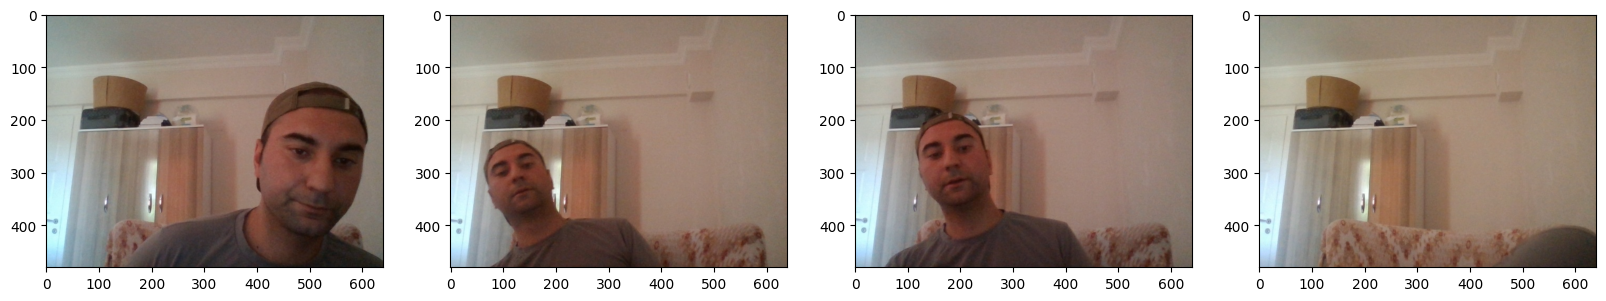

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Partition Unaugmented Data

3.2 Move the Matching Labels

In [29]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)     

# 4. Apply Image Augmentation on Images and Labels using Albumentations

4.1 Setup Albumentations Transform Pipeline

In [30]:
import albumentations as alb

In [31]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

4.2 Load a Test Image and Annotation with OpenCV and JSON

In [32]:
img = cv2.imread(os.path.join('data','train', 'images','d4cec5ed-005b-11ee-94a4-04cf4b415632.jpg'))

In [33]:
with open(os.path.join('data', 'train', 'labels', 'd4cec5ed-005b-11ee-94a4-04cf4b415632.json'), 'r') as f:
    label = json.load(f)

In [34]:
label['shapes'][0]['points']

[[272.0304568527919, 124.26395939086295],
 [452.74111675126903, 350.65989847715736]]

4.3 Extract Coordinates and Rescale to Match Image Resolution

In [36]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [37]:
coords

[272.0304568527919, 124.26395939086295, 452.74111675126903, 350.65989847715736]

In [38]:
coords = list(np.divide(coords, [640,480,640,480]))

In [39]:
coords

[0.4250475888324873,
 0.25888324873096447,
 0.7074079949238579,
 0.7305414551607445]

4.4 Apply Augmentations and View Results

In [40]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['Umut'])

In [41]:
augmented['bboxes'][0][2:]

(0.9572024816694867, 0.728302312464749)

In [42]:
augmented['bboxes']

[(0.5556232374506486,
  0.22520022560631703,
  0.9572024816694867,
  0.728302312464749)]

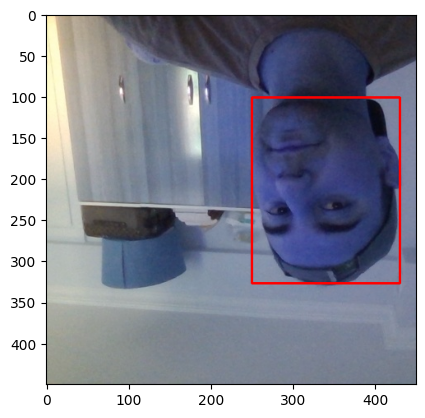

In [43]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [44]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

5.2 Load Augmented Images to Tensorflow Dataset

In [48]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [45]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [46]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [49]:
train_images.as_numpy_iterator().next()

array([[[0.30723038, 0.28713235, 0.24301471],
        [0.3060049 , 0.26905638, 0.23431373],
        [0.29846814, 0.26170343, 0.22640932],
        ...,
        [0.18817402, 0.18198529, 0.1927696 ],
        [0.20814951, 0.19295344, 0.20716912],
        [0.18921569, 0.184375  , 0.20214461]],

       [[0.35373774, 0.31599265, 0.29883578],
        [0.2817402 , 0.23866421, 0.22395833],
        [0.28284314, 0.240625  , 0.22463235],
        ...,
        [0.17830883, 0.17830883, 0.18615197],
        [0.21066177, 0.21323529, 0.2283701 ],
        [0.19313726, 0.19215687, 0.21047795]],

       [[0.3514706 , 0.33400735, 0.32224265],
        [0.2721201 , 0.25104168, 0.23976716],
        [0.29050246, 0.27371323, 0.26158088],
        ...,
        [0.19160539, 0.18376225, 0.19552696],
        [0.21917892, 0.21133578, 0.22996323],
        [0.19393383, 0.18216912, 0.2096201 ]],

       ...,

       [[0.51795346, 0.49834558, 0.48511028],
        [0.5210784 , 0.50147057, 0.48480392],
        [0.5450368 , 0

# 6. Prepare Labels

6.1 Build Label Loading Function

In [50]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

6.2 Load Labels to Tensorflow Dataset

In [51]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [53]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.3845, 0.256 , 0.759 , 0.799 ], dtype=float16))

# 7. Combine Label and Image Samples

7.1 Check Partition Lengths

In [55]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2520, 2520, 600, 600, 480, 480)

7.2 Create Final Datasets (Images/Labels)

In [56]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [57]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [58]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [59]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.1511 , 0.335  , 0.768  ],
        [0.08887, 0.3035 , 0.522  , 0.8247 ],
        [0.     , 0.11646, 0.3008 , 0.7446 ],
        [0.0949 , 0.2281 , 0.421  , 0.6216 ],
        [0.     , 0.2676 , 0.4656 , 0.908  ],
        [0.1138 , 0.2122 , 0.5244 , 0.7695 ],
        [0.4548 , 0.3315 , 0.799  , 0.8086 ],
        [0.8604 , 0.2289 , 1.     , 0.529  ]], dtype=float16))

7.3 View Images and Annotations

In [60]:
data_samples = train.as_numpy_iterator()

In [61]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


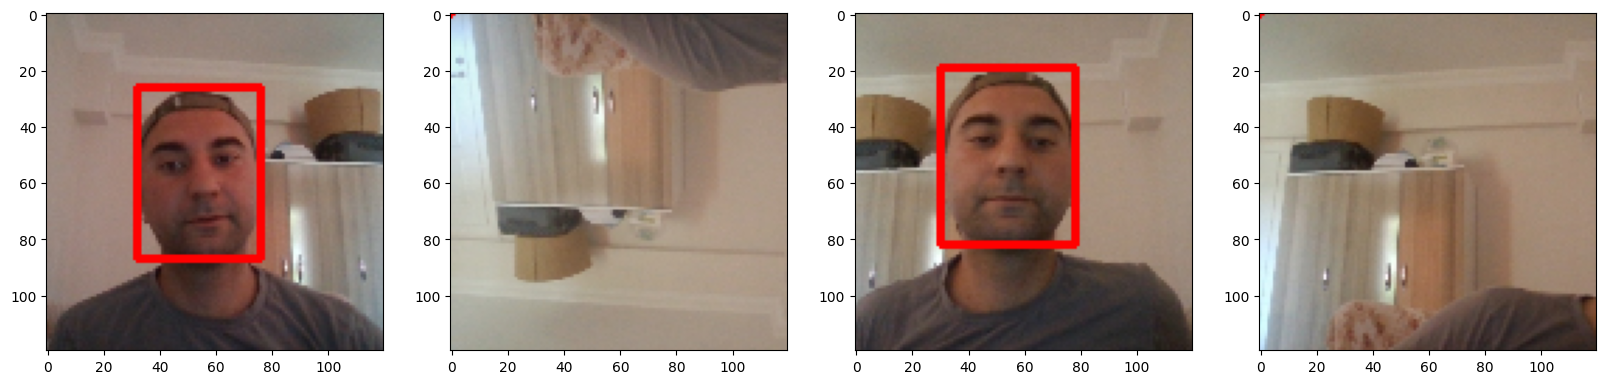

In [62]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

8.1 Import Layers and Base Network

In [63]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

8.2 Download VGG16

In [64]:
vgg = VGG16(include_top=False)

In [65]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

8.3 Build instance of Network

In [66]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

8.4 Test out Neural Network

In [67]:
facetracker = build_model()

In [68]:
facetracker = build_model()

In [69]:
X, y = train.as_numpy_iterator().next()

In [70]:
X.shape

(8, 120, 120, 3)

In [71]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 480ms/step


In [72]:
classes, coords

(array([[0.44605142],
        [0.45391256],
        [0.44289365],
        [0.48602286],
        [0.5096372 ],
        [0.48754707],
        [0.50111514],
        [0.4630025 ]], dtype=float32),
 array([[0.46643585, 0.34535503, 0.4310964 , 0.4747891 ],
        [0.41553304, 0.4288413 , 0.43721145, 0.4157165 ],
        [0.47077212, 0.3749513 , 0.39433637, 0.41673765],
        [0.4323389 , 0.3640214 , 0.41032314, 0.4806668 ],
        [0.4915736 , 0.31504384, 0.43365476, 0.4781311 ],
        [0.51336414, 0.3166563 , 0.4965606 , 0.4032737 ],
        [0.44392818, 0.34516534, 0.40495402, 0.45526144],
        [0.46937189, 0.31718794, 0.44344115, 0.44581047]], dtype=float32))

# 9. Define Losses and Optimizers

9.1 Define Optimizer and LR

In [73]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

9.2 Create Localization Loss and Classification Loss

In [74]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [75]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

9.3 Test out Loss Metrics

In [76]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.81538>

In [77]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7483078>

In [78]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.81538>

# 10. Train Neural Network

10.1 Create Custom Model Class

In [79]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [80]:
model = FaceTracker(facetracker)

In [81]:
model.compile(opt, classloss, regressloss)

10.2 Train

In [82]:
logdir='logs'

In [83]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [84]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [85]:
tf.config.list_physical_devices('GPU')

[]

In [86]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [87]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
315/315 [==============================] - 355s 1s/step - total_loss: 0.3502 - class_loss: 0.0860 - regress_loss: 0.3072 - val_total_loss: 0.0318 - val_class_loss: 8.5002e-04 - val_regress_loss: 0.0314
Epoch 2/10
315/315 [==============================] - 353s 1s/step - total_loss: 0.0813 - class_loss: 0.0172 - regress_loss: 0.0727 - val_total_loss: 0.7320 - val_class_loss: 0.6808 - val_regress_loss: 0.3916
Epoch 3/10
315/315 [==============================] - 373s 1s/step - total_loss: 0.0680 - class_loss: 0.0263 - regress_loss: 0.0549 - val_total_loss: 0.0503 - val_class_loss: 0.0250 - val_regress_loss: 0.0378
Epoch 4/10
315/315 [==============================] - 372s 1s/step - total_loss: 0.0359 - class_loss: 0.0131 - regress_loss: 0.0294 - val_total_loss: 0.0115 - val_class_loss: 1.1072e-04 - val_regress_loss: 0.0114
Epoch 5/10
315/315 [==============================] - 381s 1s/step - total_loss: 0.0263 - class_loss: 0.0088 - regress_loss: 0.0219 - val_total_loss: 0.0358

In [88]:
hist.history

{'total_loss': [0.05897177383303642,
  0.06345993280410767,
  0.04833752289414406,
  0.021624481305480003,
  0.011537997983396053,
  0.0076779262162745,
  1.586733102798462,
  0.00633449899032712,
  0.0427943617105484,
  0.005543503910303116],
 'class_loss': [0.002010306576266885,
  0.0019171666353940964,
  0.020068427547812462,
  0.00033425030414946377,
  4.8580106522422284e-05,
  0.0001205701773869805,
  0.9664102792739868,
  7.242252468131483e-05,
  0.012489957734942436,
  0.000777644629124552],
 'regress_loss': [0.05796661972999573,
  0.06250134855508804,
  0.03830330818891525,
  0.021457355469465256,
  0.011513708159327507,
  0.007617641240358353,
  1.1035280227661133,
  0.006298287771642208,
  0.03654938191175461,
  0.005154681392014027],
 'val_total_loss': [0.03178580105304718,
  0.7320064306259155,
  0.05026891082525253,
  0.011485313065350056,
  0.03583516553044319,
  0.03649240732192993,
  0.06452789902687073,
  0.020063936710357666,
  0.013546166010200977,
  0.03156639635562

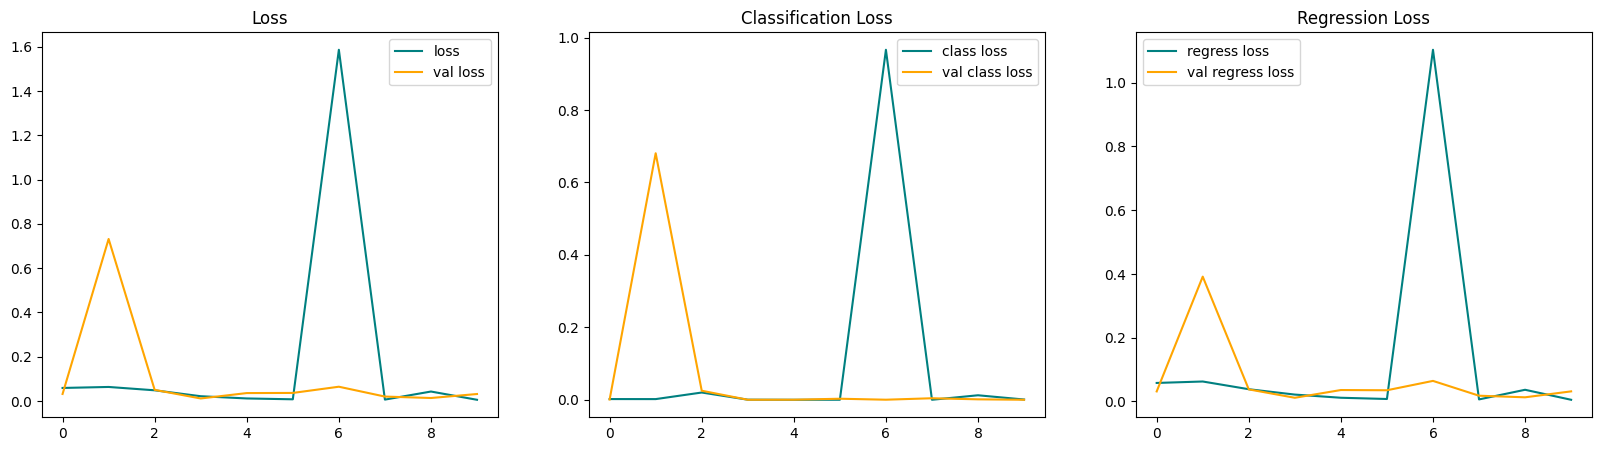

In [89]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

11.1 Make Predictions on Test Set

In [90]:
test_data = test.as_numpy_iterator()

In [91]:
test_sample = test_data.next()

In [92]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 171ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


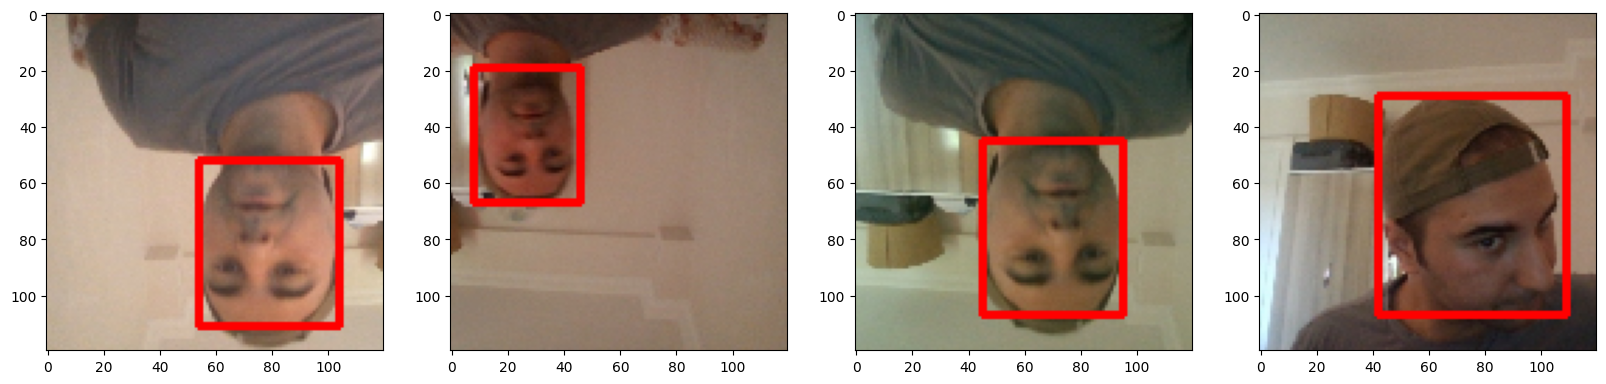

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

11.2 Save the Model

In [94]:
from tensorflow.keras.models import load_model

In [95]:
facetracker.save('facetracker.h5')

In [96]:
facetracker = load_model('facetracker.h5')

11.3 Real Time Detection

In [98]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.9: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (0,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'Face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
    
    cv2.imshow('Face', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 42ms/step
